In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Carregamento arquivo de pré-processamento

In [2]:
%run "/content/drive/My Drive/pre_processamento_TCC.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
CPU times: user 1min 45s, sys: 10.2 s, total: 1min 56s
Wall time: 2min 25s
Ataque de exploração UDPLag:  Label
BENIGN       3705
UDP-lag    366461
dtype: int64 

Ataque de exploração Syn:  Label
BENIGN        392
Syn       1582289
dtype: int64 

Ataque de exploração LDAP:  Label
BENIGN           1612
DrDoS_LDAP    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
BENIGN              1707
DrDoS_NetBIOS    4093279
dtype: int64
Ataque de exploração UDPLag:  Label
0      3705
1    366461
dtype: int64 

Ataque de exploração Syn:  Label
0        392
1    1582289
dtype: int64 

Ataque de exploração LDAP:  Label
0       1612
1    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
0       1707
1    4093279
dtype: int64


In [3]:
syn = syn.sample(333763)
print(syn.groupby(by=' Label').size())

 Label
0        99
1    333664
dtype: int64


### Bibliotecas


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### Divisão do conjunto em treino e teste


In [5]:
syn

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
565799,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
959880,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
814876,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
981026,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
670618,100,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40000.0,33.333333,56.002976,98.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,40,40,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,2,0,5840,0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787422,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1202438,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
733204,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
283994,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0

Preparação dos dados treino e teste


In [6]:
X = syn.iloc[:, 0:77]
y = syn.iloc[:,- 1]

70% para treino, 30% para teste

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                    random_state=42)

In [8]:
# Formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# Tamanho dos conjuntos
print('Amostras de treino: ', x_train.shape[0])
print('Amostras de teste: ', x_test.shape[0])

Formato dos dados de entrada: (233634, 77)
Amostras de treino:  233634
Amostras de teste:  100129


### Seleção dos Parâmetro
Seleção dos 15 melhores parâmetros.

In [9]:
best_features = SelectKBest(score_func=f_classif, k=15)
fit = best_features.fit(x_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_train.columns)
# concatenar quadros de dados
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # colunas de saída de nome
print(feature_scores.nlargest(15,'Score'))  # imprima 15 melhores parâmetros

                   Feature_Name          Score
10        Bwd Packet Length Min  146657.476490
46               ACK Flag Count   67369.688872
40            Packet Length Std   56592.374502
9         Bwd Packet Length Max   54092.572102
53         Avg Bwd Segment Size   52913.113092
11       Bwd Packet Length Mean   52913.113092
38            Max Packet Length   46033.674477
12        Bwd Packet Length Std   38651.344844
8         Fwd Packet Length Std   36469.875956
67             act_data_pkt_fwd   35085.675791
41       Packet Length Variance   29680.040604
48               CWE Flag Count   28569.935319
47               URG Flag Count   27713.489930
3   Total Length of Fwd Packets   25535.386701
62            Subflow Fwd Bytes   25535.386701


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [30 31 32 42 45 49 55 56 57 58 59 60] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
feature = feature_scores.nlargest(15,'Score')
feature

,Feature_Name,Score
10,Bwd Packet Length Min,146657.476490
46,ACK Flag Count,67369.688872
40,Packet Length Std,56592.374502
9,Bwd Packet Length Max,54092.572102
53,Avg Bwd Segment Size,52913.113092
11,Bwd Packet Length Mean,52913.113092
38,Max Packet Length,46033.674477
12,Bwd Packet Length Std,38651.344844
8,Fwd Packet Length Std,36469.875956
67,act_data_pkt_fwd,35085.675791


Exlusão dos parâmetros que não seram usados no modelo.


In [11]:
syn.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SY

In [12]:
x_train = x_train.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

x_test = x_test.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

### Normalização dos dados

In [13]:
normalizador = MinMaxScaler()
x_train= normalizador.fit_transform(x_train)
x_test = normalizador.fit_transform(x_test)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

### Formatação do tensor em 3D

In [14]:
x_train= x_train.reshape(-1, 233634, 15)
y_train= y_train.reshape(-1, 233634, 1)
x_test = x_test.reshape(-1, 100129, 15)
y_test = y_test.reshape(-1, 100129, 1)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1, 233634, 15)
(1, 233634, 1)
(1, 100129, 15)
(1, 100129, 1)


### Rede Neural Recorrente (LSTM)

#### Experimento 1

In [16]:
%%time
model1 = Sequential()
model1.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

# Camada Final
model1.add(Dense(1, activation='sigmoid'))

# Compile model
model1.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model1.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2504 - accuracy: 0.0317 - auc: 0.4999 - recall: 0.0315 - precision: 0.9991 - root_mean_squared_error: 0.5004 - val_loss: 0.2414 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4913
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2413 - accuracy: 0.9997 - auc: 0.4973 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4912 - val_loss: 0.2333 - val_accuracy: 0.9996 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4830
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2333 - accuracy: 0.9997 - auc: 0.5422 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4830 - val_loss: 0.2240 - val_accuracy: 0.9996 - val_auc: 0.5008 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4733
Epoch 4/50
1/1 [===============

In [17]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 233634, 20)        2880      
_________________________________________________________________
dropout (Dropout)            (None, 233634, 20)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 233634, 10)        8

In [18]:
checkpointer1 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer1], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00400, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0078 - accuracy: 0.9997 - auc: 0.5016 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0881 - val_loss: 0.0040 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0632
Epoch 2/50

Epoch 00002: val_loss improved from 0.00400 to 0.00386, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0075 - accuracy: 0.9997 - auc: 0.5158 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0867 - val_loss: 0.0039 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0621
Epoch 3/50

Epoch 00003: val_loss improved from 0.00386 to 0.00373, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0073 - accuracy: 0.9997 - auc: 0.4770 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0856 - val_loss

In [19]:
scores1 = model1.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores1[0]*100))
print("Acurácia: %.2f%%" % (scores1[1]*100))
print("AUC: %.2f%%" % (scores1[2]*100))
print("Recall: %.2f%%" % (scores1[3]*100))
print("Precision: %.2f%%" % (scores1[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores1[5]*100))

LDAP
Loss: 0.10%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.19%


#### Experimento 2

In [20]:
%%time
model2 = Sequential()
model2.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

# Camada Final
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model2.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2501 - accuracy: 0.0538 - auc: 0.4996 - recall: 0.0536 - precision: 0.9997 - root_mean_squared_error: 0.5001 - val_loss: 0.2441 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4941
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2441 - accuracy: 0.9997 - auc: 0.4729 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4941 - val_loss: 0.2387 - val_accuracy: 0.9996 - val_auc: 0.5001 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4886
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2387 - accuracy: 0.9997 - auc: 0.5112 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4886 - val_loss: 0.2323 - val_accuracy: 0.9996 - val_auc: 0.4960 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4820
Epoch 4/50
1/1 [===============

In [21]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_4 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_6 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 233634, 10)       

In [22]:
checkpointer2 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer2], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00918, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0154 - accuracy: 0.9997 - auc: 0.4878 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1241 - val_loss: 0.0092 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0958
Epoch 2/50

Epoch 00002: val_loss improved from 0.00918 to 0.00886, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0150 - accuracy: 0.9997 - auc: 0.4771 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1223 - val_loss: 0.0089 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0941
Epoch 3/50

Epoch 00003: val_loss improved from 0.00886 to 0.00855, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0146 - accuracy: 0.9997 - auc: 0.5177 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1209 - val_loss

In [23]:
scores2 = model2.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores2[0]*100))
print("Acurácia: %.2f%%" % (scores2[1]*100))
print("AUC: %.2f%%" % (scores2[2]*100))
print("Recall: %.2f%%" % (scores2[3]*100))
print("Precision: %.2f%%" % (scores2[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores2[5]*100))

LDAP
Loss: 0.21%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 4.59%


#### Experimento 3

In [24]:
%%time
model3 = Sequential()
model3.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

# Camada Final
model3.add(Dense(1, activation='sigmoid'))

# Compile model
model3.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model3.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2498 - accuracy: 0.8797 - auc: 0.5001 - recall: 0.8799 - precision: 0.9997 - root_mean_squared_error: 0.4998 - val_loss: 0.2404 - val_accuracy: 0.9996 - val_auc: 0.5002 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4903
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2412 - accuracy: 0.9996 - auc: 0.4870 - recall: 0.9999 - precision: 0.9997 - root_mean_squared_error: 0.4911 - val_loss: 0.2305 - val_accuracy: 0.9996 - val_auc: 0.5053 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4801
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2317 - accuracy: 0.9996 - auc: 0.5634 - recall: 0.9999 - precision: 0.9997 - root_mean_squared_error: 0.4814 - val_loss: 0.2176 - val_accuracy: 0.9996 - val_auc: 0.5687 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4664
Epoch 4/50
1/1 [===============

In [25]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_8 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_10 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 233634, 10)       

In [26]:
checkpointer3 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist3 = model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer3], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00953, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0158 - accuracy: 0.9997 - auc: 0.5613 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1256 - val_loss: 0.0095 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0976
Epoch 2/50

Epoch 00002: val_loss improved from 0.00953 to 0.00922, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0155 - accuracy: 0.9997 - auc: 0.4932 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1243 - val_loss: 0.0092 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0960
Epoch 3/50

Epoch 00003: val_loss improved from 0.00922 to 0.00893, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0150 - accuracy: 0.9997 - auc: 0.4873 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1224 - val_loss

In [27]:
scores3 = model3.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores3[0]*100))
print("Acurácia: %.2f%%" % (scores3[1]*100))
print("AUC: %.2f%%" % (scores3[2]*100))
print("Recall: %.2f%%" % (scores3[3]*100))
print("Precision: %.2f%%" % (scores3[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores3[5]*100))

LDAP
Loss: 0.21%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 4.55%


#### Experimento 4

In [28]:
%%time
model4 = Sequential()
model4.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

# Camada Final
model4.add(Dense(1, activation='sigmoid'))

# Compile model
model4.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model4.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2500 - accuracy: 0.4450 - auc: 0.4999 - recall: 0.4449 - precision: 0.9998 - root_mean_squared_error: 0.5000 - val_loss: 0.2432 - val_accuracy: 0.9996 - val_auc: 0.5012 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4932
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2435 - accuracy: 0.9959 - auc: 0.5439 - recall: 0.9962 - precision: 0.9997 - root_mean_squared_error: 0.4934 - val_loss: 0.2368 - val_accuracy: 0.9996 - val_auc: 0.4985 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4866
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2372 - accuracy: 0.9951 - auc: 0.5040 - recall: 0.9954 - precision: 0.9997 - root_mean_squared_error: 0.4870 - val_loss: 0.2289 - val_accuracy: 0.9996 - val_auc: 0.5135 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4785
Epoch 4/50
1/1 [===============

In [29]:
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_12 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 233634, 10)       

In [30]:
checkpointer4 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist4 = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer4], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00670, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0138 - accuracy: 0.9996 - auc: 0.4959 - recall: 0.9998 - precision: 0.9997 - root_mean_squared_error: 0.1177 - val_loss: 0.0067 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0818
Epoch 2/50

Epoch 00002: val_loss improved from 0.00670 to 0.00645, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0134 - accuracy: 0.9995 - auc: 0.5618 - recall: 0.9998 - precision: 0.9997 - root_mean_squared_error: 0.1159 - val_loss: 0.0064 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0803
Epoch 3/50

Epoch 00003: val_loss improved from 0.00645 to 0.00621, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0131 - accuracy: 0.9996 - auc: 0.4775 - recall: 0.9999 - precision: 0.9997 - root_mean_squared_error: 0.1143 - val_loss

In [31]:
scores4 = model4.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores4[0]*100))
print("Acurácia: %.2f%%" % (scores4[1]*100))
print("AUC: %.2f%%" % (scores4[2]*100))
print("Recall: %.2f%%" % (scores4[3]*100))
print("Precision: %.2f%%" % (scores4[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores4[5]*100))

LDAP
Loss: 0.15%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.90%


#### Experimento 5

In [32]:
%%time
model5 = Sequential()
model5.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

# Camada Final
model5.add(Dense(1, activation='sigmoid'))

# Compile model
model5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model5.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2504 - accuracy: 0.1839 - auc: 0.4977 - recall: 0.1837 - precision: 0.9997 - root_mean_squared_error: 0.5004 - val_loss: 0.2363 - val_accuracy: 0.9996 - val_auc: 0.4992 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4861
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2364 - accuracy: 0.9971 - auc: 0.4570 - recall: 0.9974 - precision: 0.9997 - root_mean_squared_error: 0.4862 - val_loss: 0.2223 - val_accuracy: 0.9996 - val_auc: 0.4974 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4715
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2225 - accuracy: 0.9979 - auc: 0.4947 - recall: 0.9982 - precision: 0.9997 - root_mean_squared_error: 0.4717 - val_loss: 0.2043 - val_accuracy: 0.9996 - val_auc: 0.5041 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4520
Epoch 4/50
1/1 [===============

In [33]:
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_16 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_18 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 233634, 10)       

In [34]:
checkpointer5 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist5 = model5.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer5], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00336, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0081 - accuracy: 0.9997 - auc: 0.5237 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0898 - val_loss: 0.0034 - val_accuracy: 0.9996 - val_auc: 0.4997 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0579
Epoch 2/50

Epoch 00002: val_loss improved from 0.00336 to 0.00324, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0078 - accuracy: 0.9997 - auc: 0.5288 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0886 - val_loss: 0.0032 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0569
Epoch 3/50

Epoch 00003: val_loss improved from 0.00324 to 0.00313, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0076 - accuracy: 0.9997 - auc: 0.5134 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0874 - val_loss

In [35]:
scores5 = model5.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores5[0]*100))
print("Acurácia: %.2f%%" % (scores5[1]*100))
print("AUC: %.2f%%" % (scores5[2]*100))
print("Recall: %.2f%%" % (scores5[3]*100))
print("Precision: %.2f%%" % (scores5[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores5[5]*100))

LDAP
Loss: 0.08%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 2.90%


#### Experimento 6

In [36]:
%%time
model6 = Sequential()
model6.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

# Camada Final
model6.add(Dense(1, activation='sigmoid'))

# Compile model
model6.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model6.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2500 - accuracy: 0.4094 - auc: 0.5000 - recall: 0.4094 - precision: 0.9997 - root_mean_squared_error: 0.5000 - val_loss: 0.2409 - val_accuracy: 0.9996 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4908
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2412 - accuracy: 0.9997 - auc: 0.4443 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4911 - val_loss: 0.2324 - val_accuracy: 0.9996 - val_auc: 0.5257 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4821
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2329 - accuracy: 0.9997 - auc: 0.4659 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4826 - val_loss: 0.2227 - val_accuracy: 0.9996 - val_auc: 0.5488 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4719
Epoch 4/50
1/1 [===============

In [37]:
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_20 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_21 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_22 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 233634, 10)       

In [38]:
checkpointer6 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist6 = model6.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer6], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00319, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0074 - accuracy: 0.9997 - auc: 0.5384 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0860 - val_loss: 0.0032 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0564
Epoch 2/50

Epoch 00002: val_loss improved from 0.00319 to 0.00306, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0071 - accuracy: 0.9997 - auc: 0.4971 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0845 - val_loss: 0.0031 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0553
Epoch 3/50

Epoch 00003: val_loss improved from 0.00306 to 0.00294, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0070 - accuracy: 0.9997 - auc: 0.4931 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0835 - val_loss

In [39]:
scores6 = model6.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores6[0]*100))
print("Acurácia: %.2f%%" % (scores6[1]*100))
print("AUC: %.2f%%" % (scores6[2]*100))
print("Recall: %.2f%%" % (scores6[3]*100))
print("Precision: %.2f%%" % (scores6[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores6[5]*100))

LDAP
Loss: 0.08%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 2.80%


#### Experimento 7

In [40]:
%%time
model7 = Sequential()
model7.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

# Camada Final
model7.add(Dense(1, activation='sigmoid'))

# Compile model
model7.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model7.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2494 - accuracy: 0.8875 - auc: 0.5045 - recall: 0.8876 - precision: 0.9997 - root_mean_squared_error: 0.4994 - val_loss: 0.2320 - val_accuracy: 0.9996 - val_auc: 0.5739 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4817
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2331 - accuracy: 0.9927 - auc: 0.4457 - recall: 0.9930 - precision: 0.9997 - root_mean_squared_error: 0.4828 - val_loss: 0.2132 - val_accuracy: 0.9996 - val_auc: 0.5978 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4617
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2149 - accuracy: 0.9933 - auc: 0.5011 - recall: 0.9935 - precision: 0.9997 - root_mean_squared_error: 0.4636 - val_loss: 0.1905 - val_accuracy: 0.9996 - val_auc: 0.5970 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4365
Epoch 4/50
1/1 [===============

In [41]:
print(model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_24 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_25 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_26 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 233634, 10)       

In [42]:
checkpointer7 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist7 = model7.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer7], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00807, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0159 - accuracy: 0.9997 - auc: 0.4947 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1259 - val_loss: 0.0081 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0899
Epoch 2/50

Epoch 00002: val_loss improved from 0.00807 to 0.00776, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0154 - accuracy: 0.9997 - auc: 0.5259 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1242 - val_loss: 0.0078 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0881
Epoch 3/50

Epoch 00003: val_loss improved from 0.00776 to 0.00745, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0150 - accuracy: 0.9997 - auc: 0.4987 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.1223 - val_loss

In [43]:
scores7 = model7.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores7[0]*100))
print("Acurácia: %.2f%%" % (scores7[1]*100))
print("AUC: %.2f%%" % (scores7[2]*100))
print("Recall: %.2f%%" % (scores7[3]*100))
print("Precision: %.2f%%" % (scores7[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores7[5]*100))

LDAP
Loss: 0.16%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 4.01%


#### Experimento 8

In [44]:
%%time
model8 = Sequential()
model8.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

# Camada Final
model8.add(Dense(1, activation='sigmoid'))

# Compile model
model8.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model8.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2503 - accuracy: 0.1878 - auc: 0.4995 - recall: 0.1876 - precision: 0.9997 - root_mean_squared_error: 0.5003 - val_loss: 0.2404 - val_accuracy: 0.9996 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4903
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2407 - accuracy: 0.9997 - auc: 0.5118 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4906 - val_loss: 0.2315 - val_accuracy: 0.9996 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4811
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2318 - accuracy: 0.9997 - auc: 0.4967 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4814 - val_loss: 0.2208 - val_accuracy: 0.9996 - val_auc: 0.5005 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4699
Epoch 4/50
1/1 [===============

In [45]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [46]:
checkpointer8 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist8 = model8.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer8], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00383, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0082 - accuracy: 0.9997 - auc: 0.5486 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0905 - val_loss: 0.0038 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0619
Epoch 2/50

Epoch 00002: val_loss improved from 0.00383 to 0.00371, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0080 - accuracy: 0.9997 - auc: 0.4326 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0895 - val_loss: 0.0037 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0609
Epoch 3/50

Epoch 00003: val_loss improved from 0.00371 to 0.00359, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0079 - accuracy: 0.9997 - auc: 0.4856 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0886 - val_loss

In [47]:
scores8 = model8.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores8[0]*100))
print("Acurácia: %.2f%%" % (scores8[1]*100))
print("AUC: %.2f%%" % (scores8[2]*100))
print("Recall: %.2f%%" % (scores8[3]*100))
print("Precision: %.2f%%" % (scores8[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores8[5]*100))

LDAP
Loss: 0.10%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.20%


#### Experimento 9

In [48]:
%%time
model9 = Sequential()
model9.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

# Camada Final
model9.add(Dense(1, activation='sigmoid'))

# Compile model
model9.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model9.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2506 - accuracy: 0.0133 - auc: 0.4959 - recall: 0.0130 - precision: 0.9993 - root_mean_squared_error: 0.5006 - val_loss: 0.2374 - val_accuracy: 0.9996 - val_auc: 0.4780 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4872
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2373 - accuracy: 0.9997 - auc: 0.5051 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4871 - val_loss: 0.2243 - val_accuracy: 0.9996 - val_auc: 0.5002 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4736
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2245 - accuracy: 0.9997 - auc: 0.4818 - recall: 0.9999 - precision: 0.9997 - root_mean_squared_error: 0.4738 - val_loss: 0.2076 - val_accuracy: 0.9996 - val_auc: 0.4969 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4556
Epoch 4/50
1/1 [===============

In [49]:
print(model9.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [50]:
checkpointer9 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist9 = model9.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer9], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00253, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0061 - accuracy: 0.9997 - auc: 0.4519 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0780 - val_loss: 0.0025 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0503
Epoch 2/50

Epoch 00002: val_loss improved from 0.00253 to 0.00245, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0059 - accuracy: 0.9997 - auc: 0.5315 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0771 - val_loss: 0.0025 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0495
Epoch 3/50

Epoch 00003: val_loss improved from 0.00245 to 0.00237, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0058 - accuracy: 0.9997 - auc: 0.4673 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0764 - val_loss

In [51]:
scores9 = model9.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores9[0]*100))
print("Acurácia: %.2f%%" % (scores9[1]*100))
print("AUC: %.2f%%" % (scores9[2]*100))
print("Recall: %.2f%%" % (scores9[3]*100))
print("Precision: %.2f%%" % (scores9[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores9[5]*100))

LDAP
Loss: 0.07%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 2.59%


#### Experimento 10

In [52]:
%%time
model10 = Sequential()
model10.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

# Camada Final
model10.add(Dense(1, activation='sigmoid'))

# Compile model
model10.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model10.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2498 - accuracy: 0.8023 - auc: 0.5000 - recall: 0.8024 - precision: 0.9998 - root_mean_squared_error: 0.4998 - val_loss: 0.2374 - val_accuracy: 0.9996 - val_auc: 0.5664 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4872
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2379 - accuracy: 0.9997 - auc: 0.4973 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.4878 - val_loss: 0.2254 - val_accuracy: 0.9996 - val_auc: 0.5006 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4748
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2261 - accuracy: 0.9997 - auc: 0.5251 - recall: 0.9999 - precision: 0.9997 - root_mean_squared_error: 0.4755 - val_loss: 0.2113 - val_accuracy: 0.9996 - val_auc: 0.5037 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4597
Epoch 4/50
1/1 [===============

In [53]:
print(model10.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_36 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_37 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_38 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 233634, 10)       

In [54]:
checkpointer10 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist10 = model10.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer10], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00121, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0035 - accuracy: 0.9997 - auc: 0.5190 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0594 - val_loss: 0.0012 - val_accuracy: 0.9996 - val_auc: 0.4997 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0348
Epoch 2/50

Epoch 00002: val_loss improved from 0.00121 to 0.00116, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0034 - accuracy: 0.9997 - auc: 0.5373 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0582 - val_loss: 0.0012 - val_accuracy: 0.9996 - val_auc: 0.4997 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0341
Epoch 3/50

Epoch 00003: val_loss improved from 0.00116 to 0.00111, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0033 - accuracy: 0.9997 - auc: 0.5516 - recall: 1.0000 - precision: 0.9997 - root_mean_squared_error: 0.0571 - val_loss

In [55]:
scores10 = model10.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores10[0]*100))
print("Acurácia: %.2f%%" % (scores10[1]*100))
print("AUC: %.2f%%" % (scores10[2]*100))
print("Recall: %.2f%%" % (scores10[3]*100))
print("Precision: %.2f%%" % (scores10[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores10[5]*100))

LDAP
Loss: 0.05%
Acurácia: 99.96%
AUC: 54.01%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 2.19%


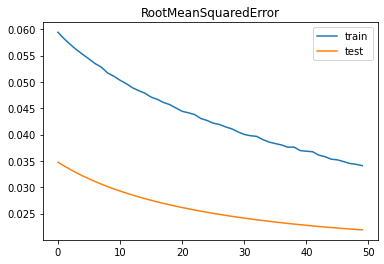

In [56]:
plt.title('RootMeanSquaredError')
plt.plot(hist10.history['root_mean_squared_error'], label='train')
plt.plot(hist10.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show();